##### Copyright 2020 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
#@title Copyright 2020 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/spice"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/spice.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/spice.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/spice.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/spice/2"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Pitch Detection with SPICE

This colab will show you how to use the SPICE model downloaded from TensorFlow Hub.

In [2]:
!sudo apt-get install -q -y timidity libsndfile1

Reading package lists...
Building dependency tree...


Reading state information...


libsndfile1 is already the newest version (1.0.28-7ubuntu0.1).


The following packages were automatically installed and are no longer required:
  libatasmart4 libblockdev-fs2 libblockdev-loop2 libblockdev-part-err2


  libblockdev-part2 libblockdev-swap2 libblockdev-utils2 libblockdev2
  libparted-fs-resize0
Use 'sudo apt autoremove' to remove them.
The following additional packages will be installed:
  fluid-soundfont-gm libao-common libao4
Suggested packages:
  fluid-soundfont-gs fluidsynth libaudio2 libsndio6.1 freepats pmidi
  timidity-daemon


The following NEW packages will be installed:
  fluid-soundfont-gm libao-common libao4 timidity


0 upgraded, 4 newly installed, 0 to remove and 169 not upgraded.
Need to get 120 MB of archives.
After this operation, 150 MB of additional disk space will be used.


Get:1 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 fluid-soundfont-gm all 3.1-5.1 [119 MB]


Get:2 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libao-common all 1.2.2+20180113-1ubuntu1 [6644 B]
Get:3 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/main amd64 libao4 amd64 1.2.2+20180113-1ubuntu1 [35.1 kB]


Get:4 http://us-central1.gce.archive.ubuntu.com/ubuntu focal/universe amd64 timidity amd64 2.14.0-8build1 [613 kB]


Fetched 120 MB in 5s (23.4 MB/s)


Selecting previously unselected package fluid-soundfont-gm.


(Reading database ... 141108 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...


Selecting previously unselected package libao-common.
Preparing to unpack .../libao-common_1.2.2+20180113-1ubuntu1_all.deb ...
Unpacking libao-common (1.2.2+20180113-1ubuntu1) ...


Selecting previously unselected package libao4:amd64.
Preparing to unpack .../libao4_1.2.2+20180113-1ubuntu1_amd64.deb ...
Unpacking libao4:amd64 (1.2.2+20180113-1ubuntu1) ...


Selecting previously unselected package timidity.


Preparing to unpack .../timidity_2.14.0-8build1_amd64.deb ...
Unpacking timidity (2.14.0-8build1) ...


Setting up libao-common (1.2.2+20180113-1ubuntu1) ...


Setting up libao4:amd64 (1.2.2+20180113-1ubuntu1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up timidity (2.14.0-8build1) ...


Processing triggers for libc-bin (2.31-0ubuntu9.9) ...
Processing triggers for man-db (2.9.1-1) ...


Processing triggers for desktop-file-utils (0.24-1ubuntu3) ...
Processing triggers for mime-support (3.64ubuntu1) ...


Processing triggers for gnome-menus (3.36.0-1ubuntu1) ...


In [3]:
# All the imports to deal with sound data
!pip install pydub librosa music21

  Using cached audioread-3.0.0-py3-none-any.whl


  Using cached soundfile-0.11.0-py2.py3-none-any.whl (23 kB)


  Using cached resampy-0.4.2-py3-none-any.whl (3.1 MB)


  Using cached pooch-1.6.0-py3-none-any.whl (56 kB)


  Using cached appdirs-1.4.4-py2.py3-none-any.whl (9.6 kB)


  Attempting uninstall: numpy


    Found existing installation: numpy 1.24.0rc2


    Uninstalling numpy-1.24.0rc2:
      Successfully uninstalled numpy-1.24.0rc2


In [4]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display as librosadisplay

import logging
import math
import statistics
import sys

from IPython.display import Audio, Javascript
from scipy.io import wavfile

from base64 import b64decode

import music21
from pydub import AudioSegment

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

print("tensorflow: %s" % tf.__version__)
#print("librosa: %s" % librosa.__version__)

2022-12-14 13:45:45.451957: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 13:45:45.452049: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 13:45:45.452058: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


tensorflow: 2.11.0


# The audio input file
Now the hardest part: Record your singing! :)

We provide four methods to obtain an audio file:

1.   Record audio directly in colab
2.   Upload from your computer
3.   Use a file saved on Google Drive
4.   Download the file from the web

Choose one of the four methods below.

In [5]:
#@title [Run this] Definition of the JS code to record audio straight from the browser

RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  try:
    from google.colab import output
  except ImportError:
    print('No possible to import output from google.colab')
    return ''
  else:
    print('Recording')
    display(Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    fname = 'recorded_audio.wav'
    print('Saving to', fname)
    b = b64decode(s.split(',')[1])
    with open(fname, 'wb') as f:
      f.write(b)
    return fname

In [6]:
#@title Select how to input your audio  { run: "auto" }
INPUT_SOURCE = 'https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav' #@param ["https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav", "RECORD", "UPLOAD", "./drive/My Drive/YOUR_MUSIC_FILE.wav"] {allow-input: true}

print('You selected', INPUT_SOURCE)

if INPUT_SOURCE == 'RECORD':
  uploaded_file_name = record(5)
elif INPUT_SOURCE == 'UPLOAD':
  try:
    from google.colab import files
  except ImportError:
    print("ImportError: files from google.colab seems to not be available")
  else:
    uploaded = files.upload()
    for fn in uploaded.keys():
      print('User uploaded file "{name}" with length {length} bytes'.format(
          name=fn, length=len(uploaded[fn])))
    uploaded_file_name = next(iter(uploaded))
    print('Uploaded file: ' + uploaded_file_name)
elif INPUT_SOURCE.startswith('./drive/'):
  try:
    from google.colab import drive
  except ImportError:
    print("ImportError: files from google.colab seems to not be available")
  else:
    drive.mount('/content/drive')
    # don't forget to change the name of the file you
    # will you here!
    gdrive_audio_file = 'YOUR_MUSIC_FILE.wav'
    uploaded_file_name = INPUT_SOURCE
elif INPUT_SOURCE.startswith('http'):
  !wget --no-check-certificate 'https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav' -O c-scale.wav
  uploaded_file_name = 'c-scale.wav'
else:
  print('Unrecognized input format!')
  print('Please select "RECORD", "UPLOAD", or specify a file hosted on Google Drive or a file from the web to download file to download')

You selected https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav
--2022-12-14 13:45:47--  https://storage.googleapis.com/download.tensorflow.org/data/c-scale-metronome.wav
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 108.177.112.128, 142.251.6.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 

200 OK
Length: 384728 (376K) [audio/wav]
Saving to: ‘c-scale.wav’

c-scale.wav         100%[===================>] 375.71K  --.-KB/s    in 0.004s  

2022-12-14 13:45:47 (99.8 MB/s) - ‘c-scale.wav’ saved [384728/384728]



# Preparing the audio data

Now we have the audio, let's convert it to the expected format and then listen to it!

The SPICE model needs as input an audio file at a sampling rate of 16kHz and with only one channel (mono). 

To help you with this part, we created a function (`convert_audio_for_model`) to convert any wav file you have to the model's expected format:

In [7]:
# Function that converts the user-created audio to the format that the model 
# expects: bitrate 16kHz and only one channel (mono).

EXPECTED_SAMPLE_RATE = 16000

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

In [8]:
# Converting to the expected format for the model
# in all the input 4 input method before, the uploaded file name is at
# the variable uploaded_file_name
converted_audio_file = convert_audio_for_model(uploaded_file_name)

In [9]:
# Loading audio samples from the wav file:
sample_rate, audio_samples = wavfile.read(converted_audio_file, 'rb')

# Show some basic information about the audio.
duration = len(audio_samples)/sample_rate
print(f'Sample rate: {sample_rate} Hz')
print(f'Total duration: {duration:.2f}s')
print(f'Size of the input: {len(audio_samples)}')

# Let's listen to the wav file.
Audio(audio_samples, rate=sample_rate)

Sample rate: 16000 Hz
Total duration: 11.89s
Size of the input: 190316


First thing, let's take a look at the waveform of our singing.

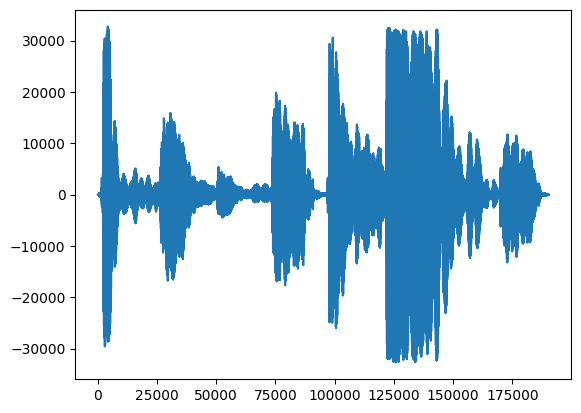

In [10]:
# We can visualize the audio as a waveform.
_ = plt.plot(audio_samples)

A more informative visualization is the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram), which shows frequencies present over time.

Here, we use a logarithmic frequency scale, to make the singing more clearly visible.


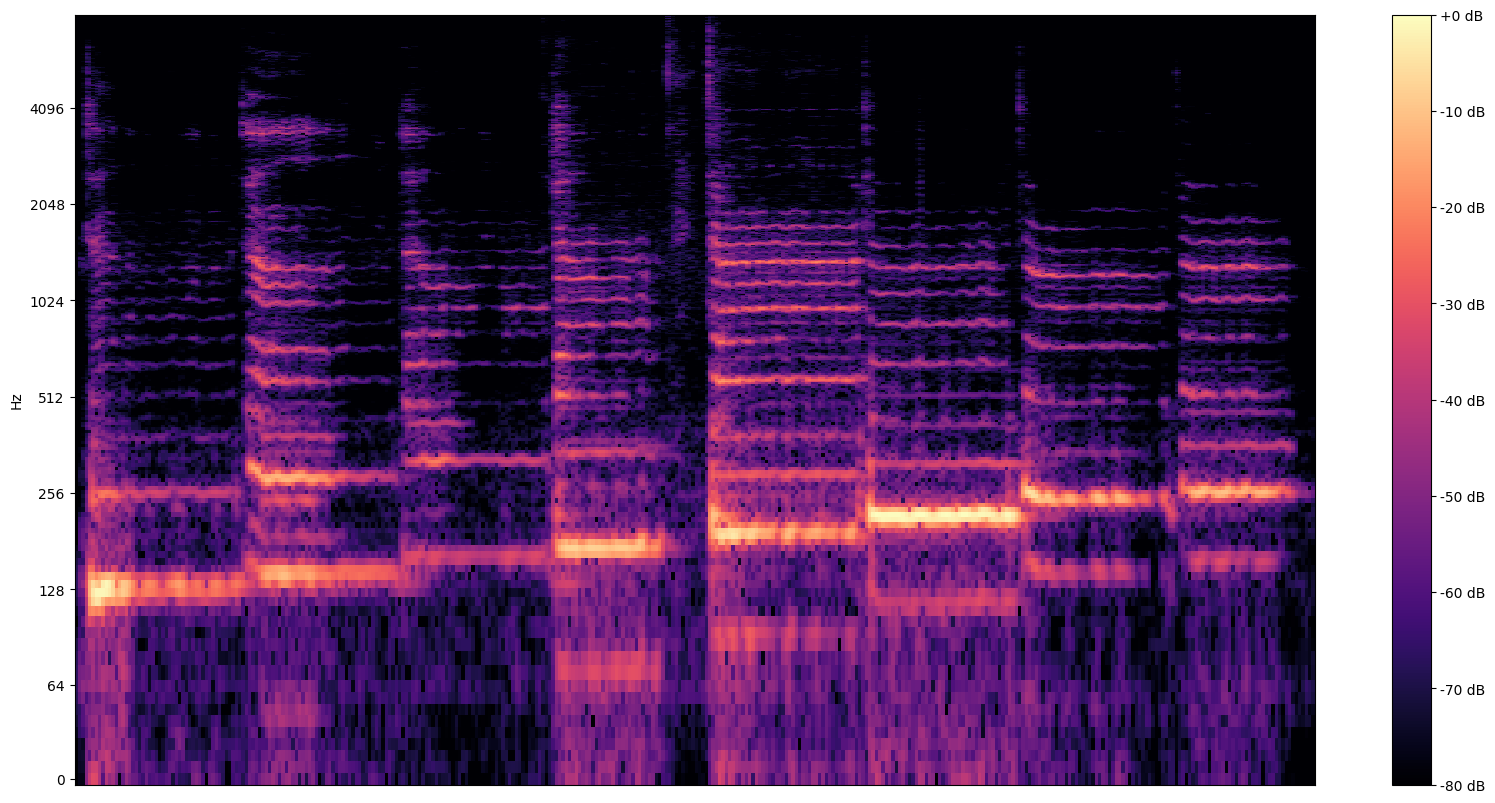

In [11]:
MAX_ABS_INT16 = 32768.0

def plot_stft(x, sample_rate, show_black_and_white=False):
  x_stft = np.abs(librosa.stft(x, n_fft=2048))
  fig, ax = plt.subplots()
  fig.set_size_inches(20, 10)
  x_stft_db = librosa.amplitude_to_db(x_stft, ref=np.max)
  if(show_black_and_white):
    librosadisplay.specshow(data=x_stft_db, y_axis='log', 
                             sr=sample_rate, cmap='gray_r')
  else:
    librosadisplay.specshow(data=x_stft_db, y_axis='log', sr=sample_rate)

  plt.colorbar(format='%+2.0f dB')

plot_stft(audio_samples / MAX_ABS_INT16 , sample_rate=EXPECTED_SAMPLE_RATE)
plt.show()


We need one last conversion here. The audio samples are in int16 format. They need to be normalized to floats between -1 and 1.

In [12]:
audio_samples = audio_samples / float(MAX_ABS_INT16)

# Executing the Model
Now is the easy part, let's load the model with **TensorFlow Hub**, and feed the audio to it.
SPICE will give us two outputs: pitch and uncertainty




**TensorFlow Hub** is a library for the publication, discovery, and consumption of reusable parts of machine learning models. It makes easy to use machine learning to solve your challenges.

To load the model you just need the Hub module and the URL pointing to the model:

In [13]:
# Loading the SPICE model is easy:
model = hub.load("https://tfhub.dev/google/spice/2")

**Note:** An interesting detail here is that all the model urls from Hub can be used for download and also to read the documentation, so if you point your browser to that link you can read documentation on how to use the model and learn more about how it was trained.

With the model loaded, data prepared, we need 3 lines to get the result: 

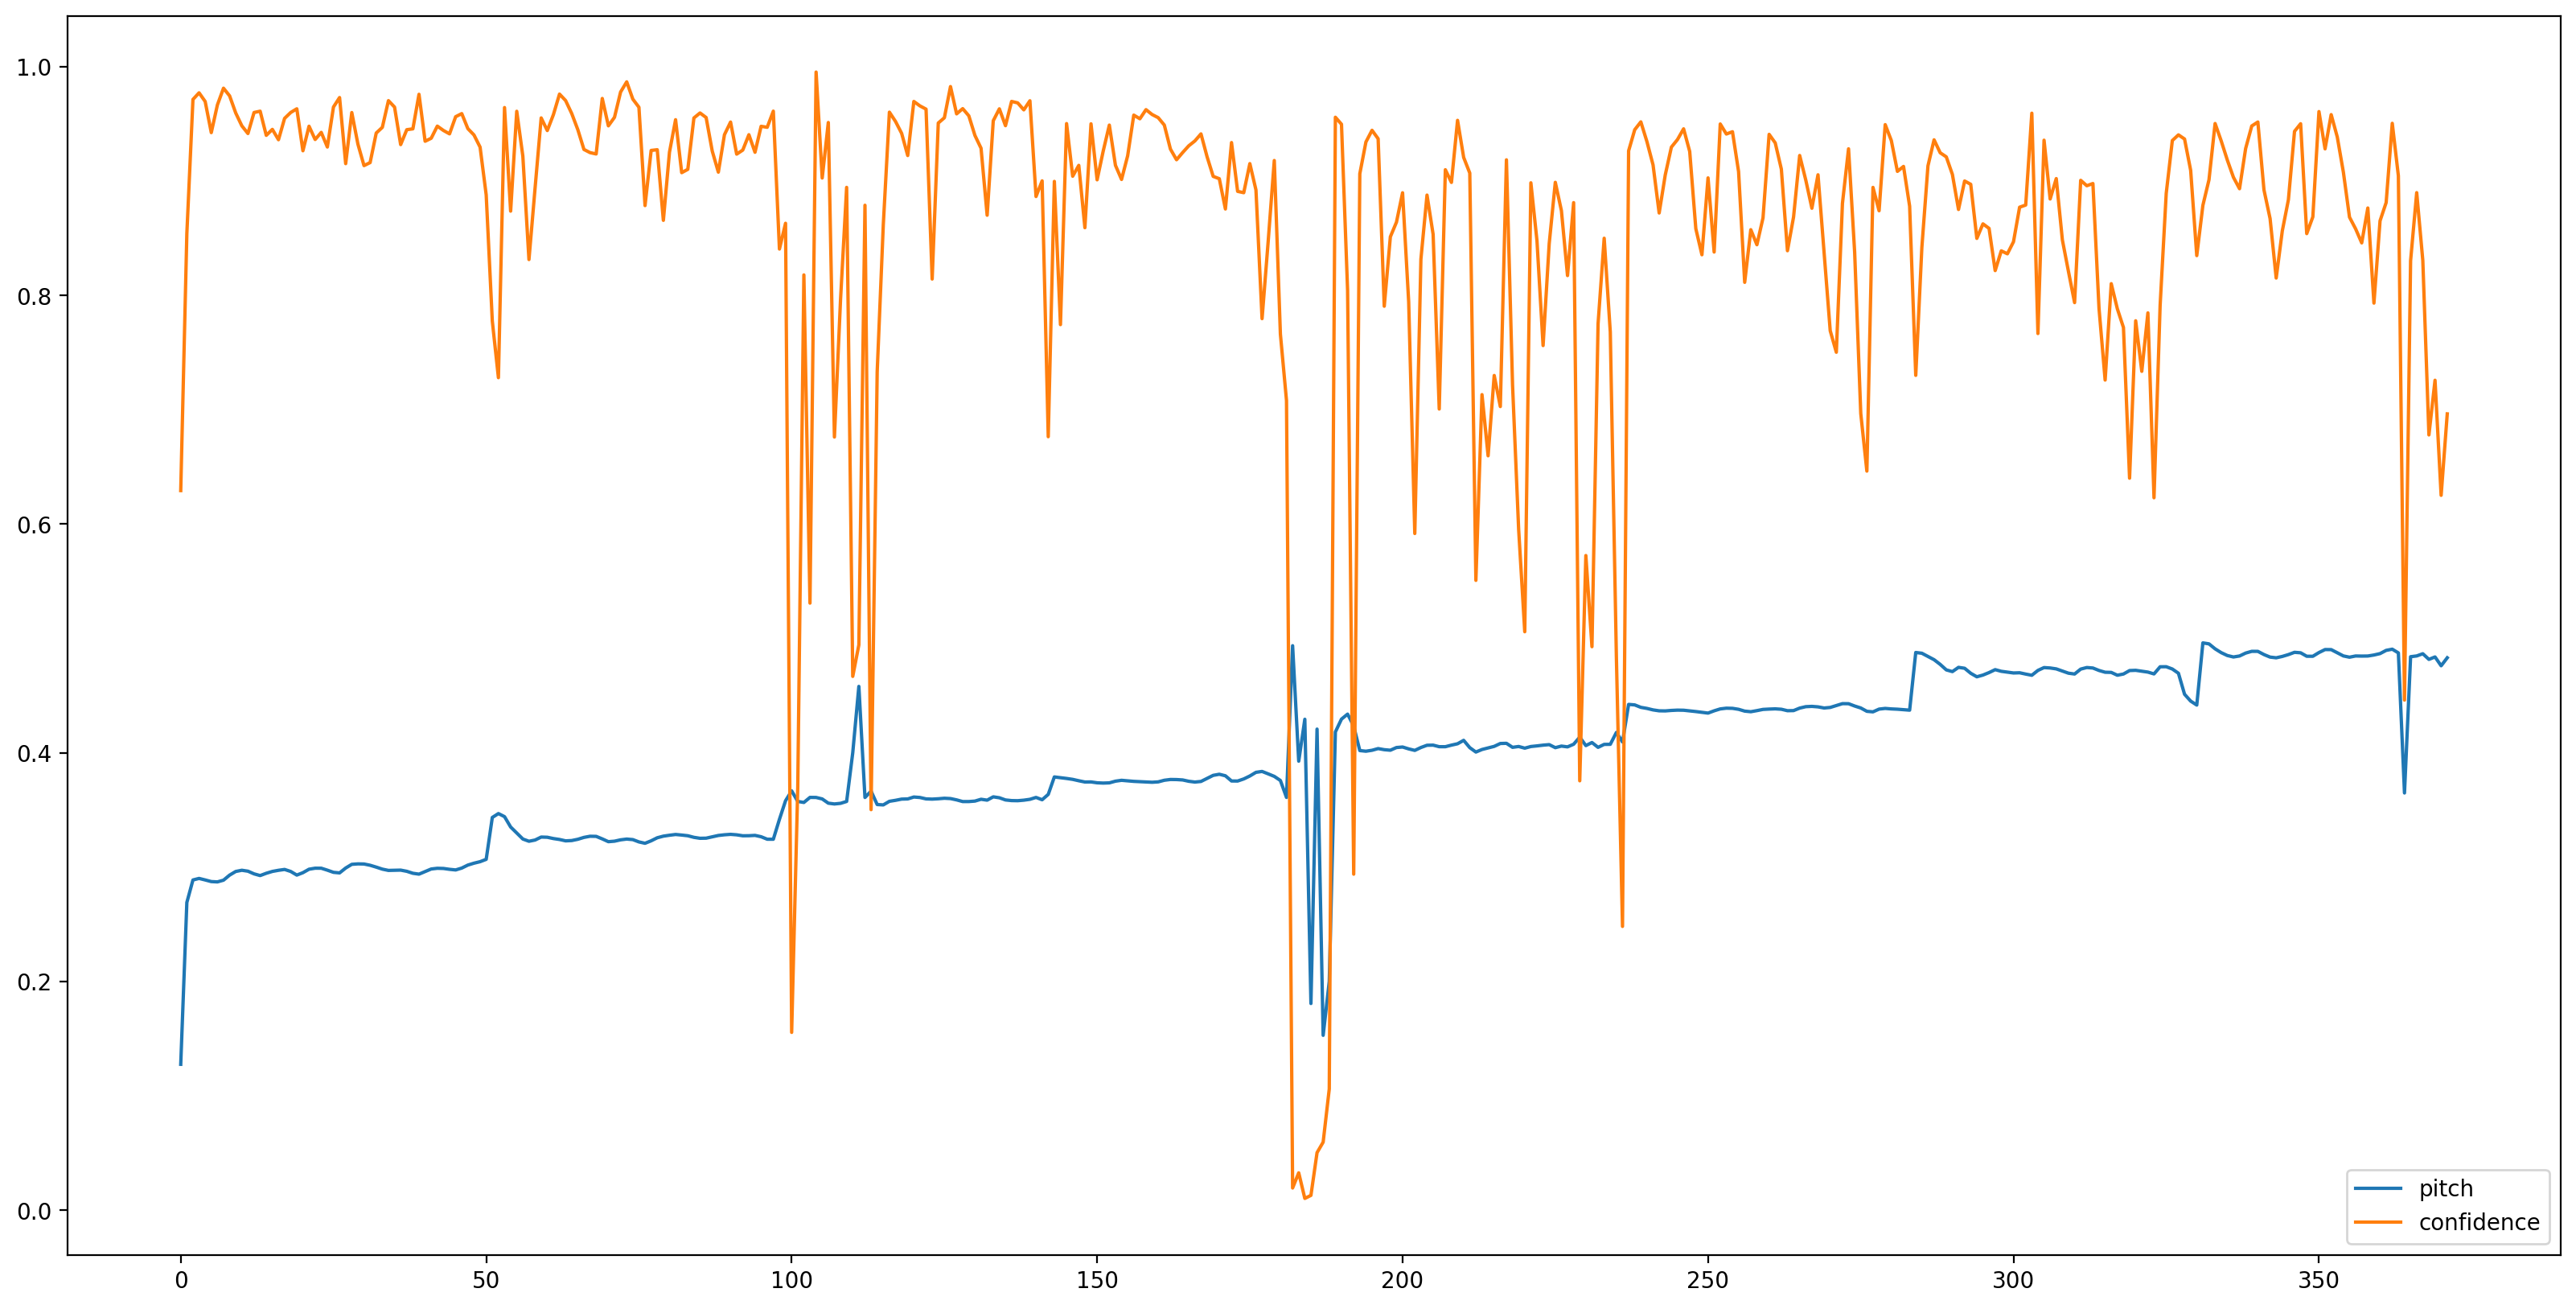

In [14]:
# We now feed the audio to the SPICE tf.hub model to obtain pitch and uncertainty outputs as tensors.
model_output = model.signatures["serving_default"](tf.constant(audio_samples, tf.float32))

pitch_outputs = model_output["pitch"]
uncertainty_outputs = model_output["uncertainty"]

# 'Uncertainty' basically means the inverse of confidence.
confidence_outputs = 1.0 - uncertainty_outputs

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
plt.plot(pitch_outputs, label='pitch')
plt.plot(confidence_outputs, label='confidence')
plt.legend(loc="lower right")
plt.show()

Let's make the results easier to understand by removing all pitch estimates with low confidence (confidence < 0.9) and plot the remaining ones.



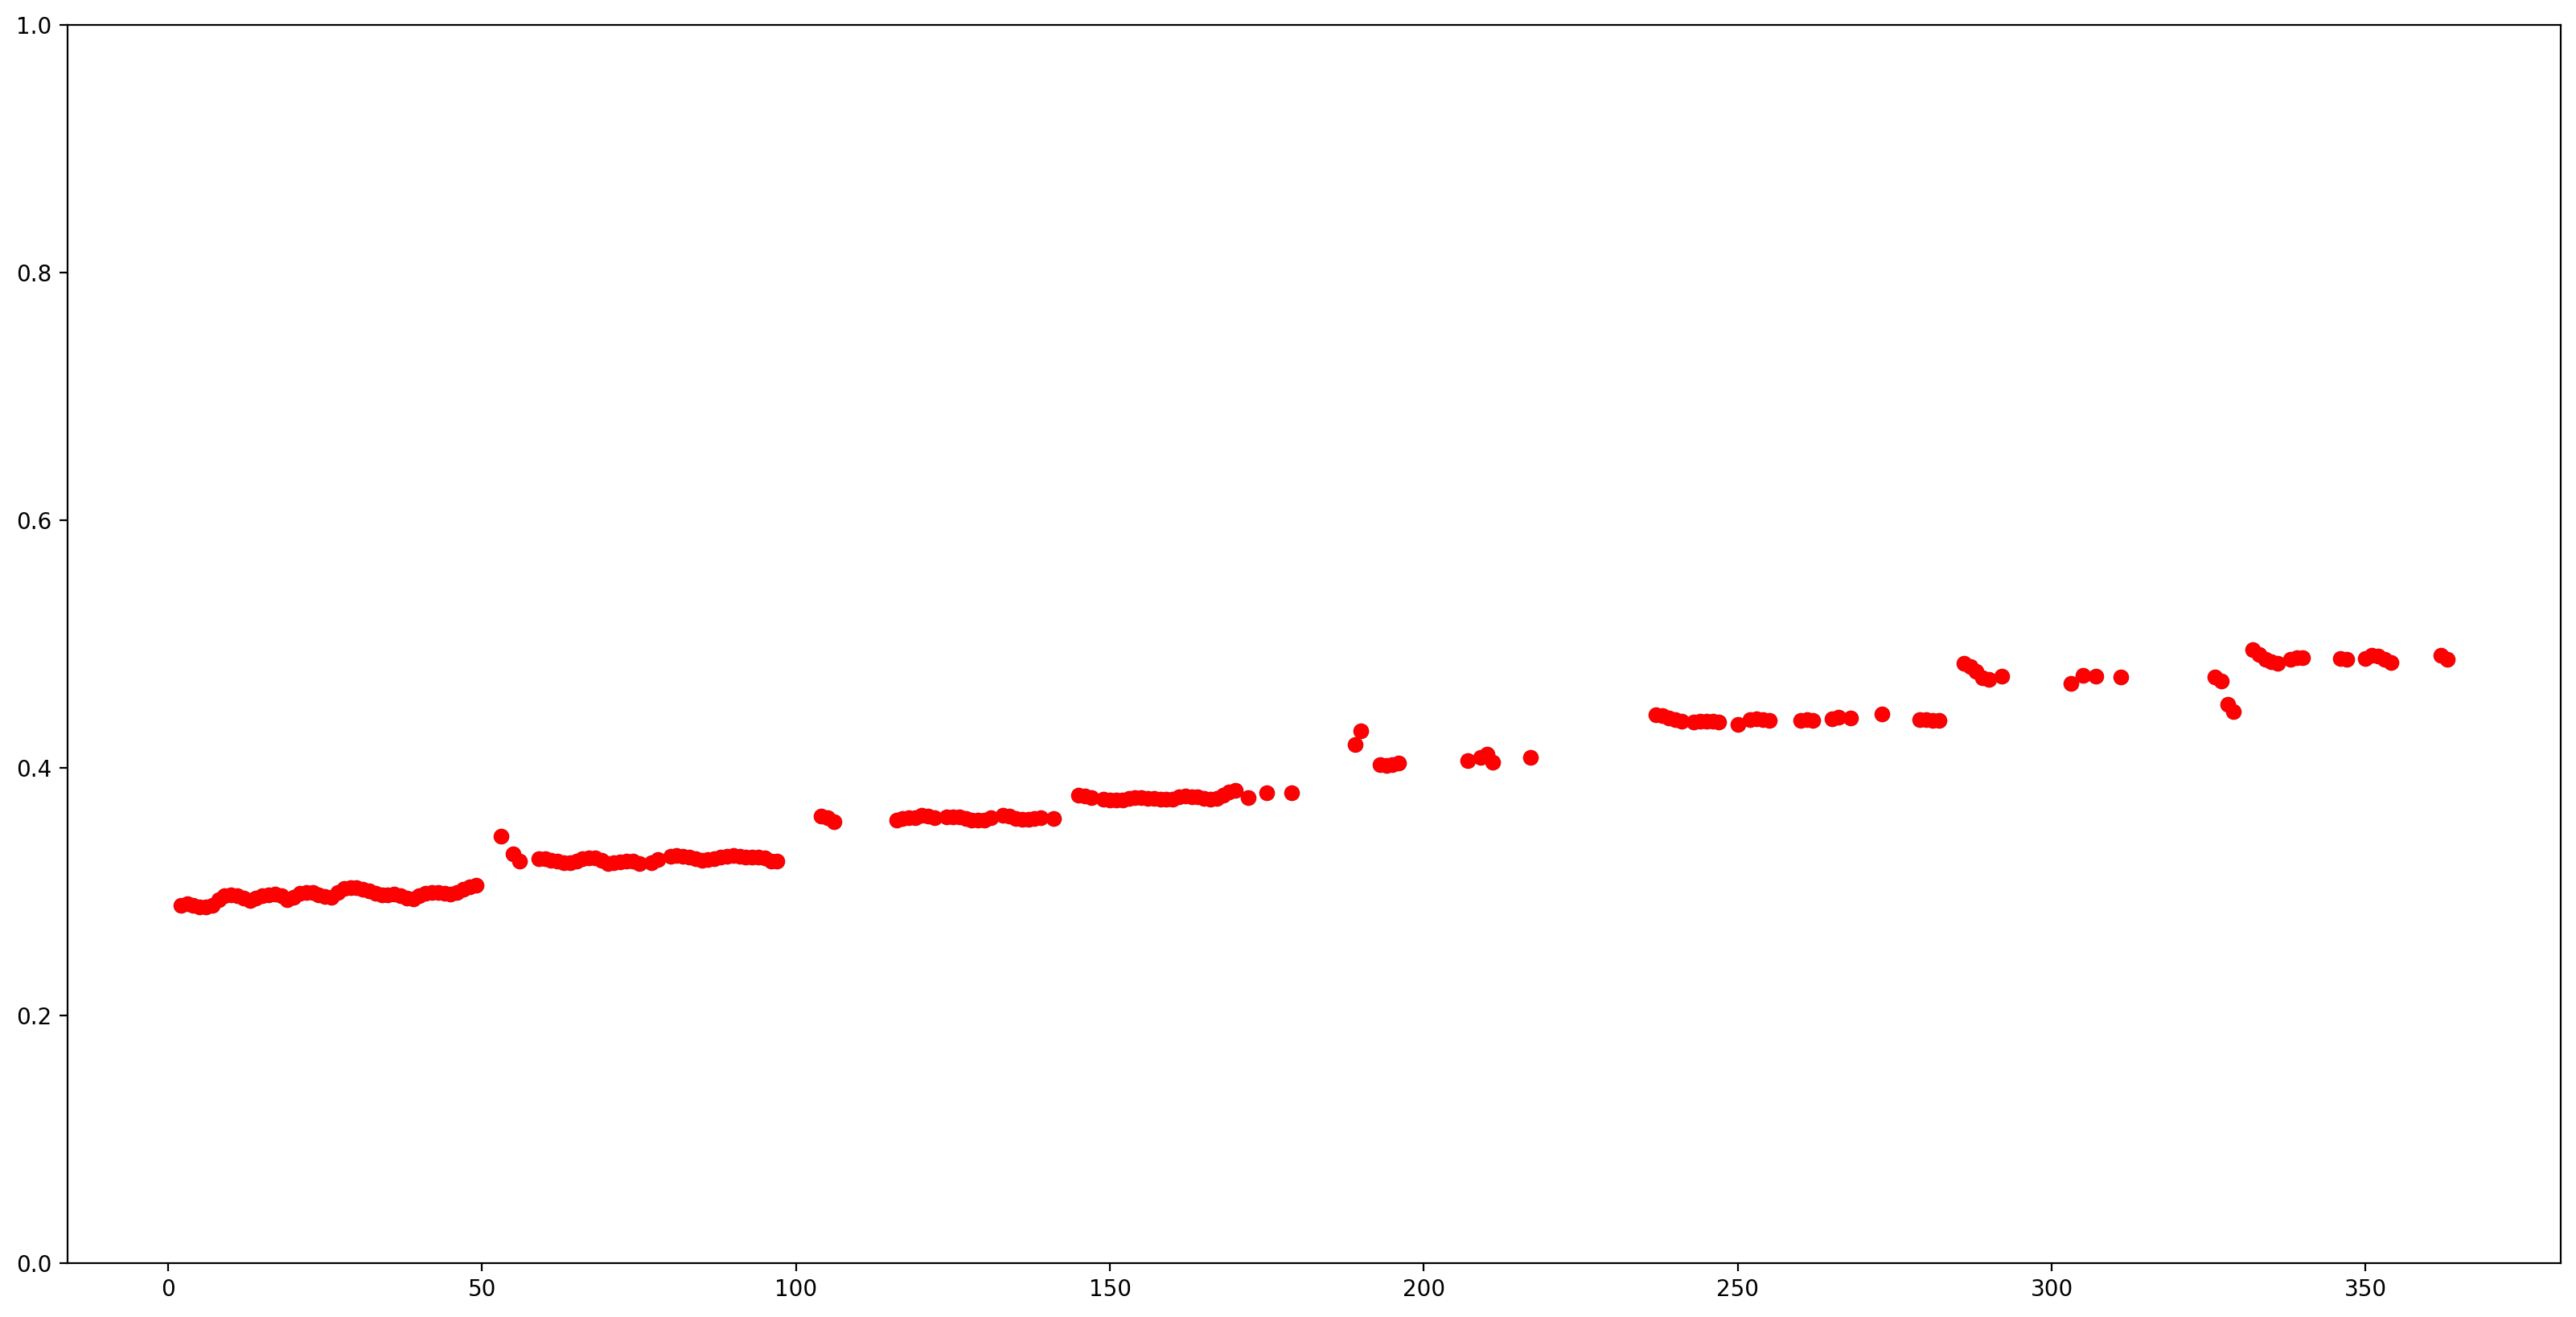

In [15]:
confidence_outputs = list(confidence_outputs)
pitch_outputs = [ float(x) for x in pitch_outputs]

indices = range(len (pitch_outputs))
confident_pitch_outputs = [ (i,p)  
  for i, p, c in zip(indices, pitch_outputs, confidence_outputs) if  c >= 0.9  ]
confident_pitch_outputs_x, confident_pitch_outputs_y = zip(*confident_pitch_outputs)
 
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.set_ylim([0, 1])
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, )
plt.scatter(confident_pitch_outputs_x, confident_pitch_outputs_y, c="r")

plt.show()

The pitch values returned by SPICE are in the range from 0 to 1. Let's convert them to absolute pitch values in Hz.

In [16]:
def output2hz(pitch_output):
  # Constants taken from https://tfhub.dev/google/spice/2
  PT_OFFSET = 25.58
  PT_SLOPE = 63.07
  FMIN = 10.0;
  BINS_PER_OCTAVE = 12.0;
  cqt_bin = pitch_output * PT_SLOPE + PT_OFFSET;
  return FMIN * 2.0 ** (1.0 * cqt_bin / BINS_PER_OCTAVE)
    
confident_pitch_values_hz = [ output2hz(p) for p in confident_pitch_outputs_y ]

Now, let's see how good the prediction is: We will overlay the predicted pitches over the original spectrogram. To make the pitch predictions more visible, we changed the spectrogram to black and white.

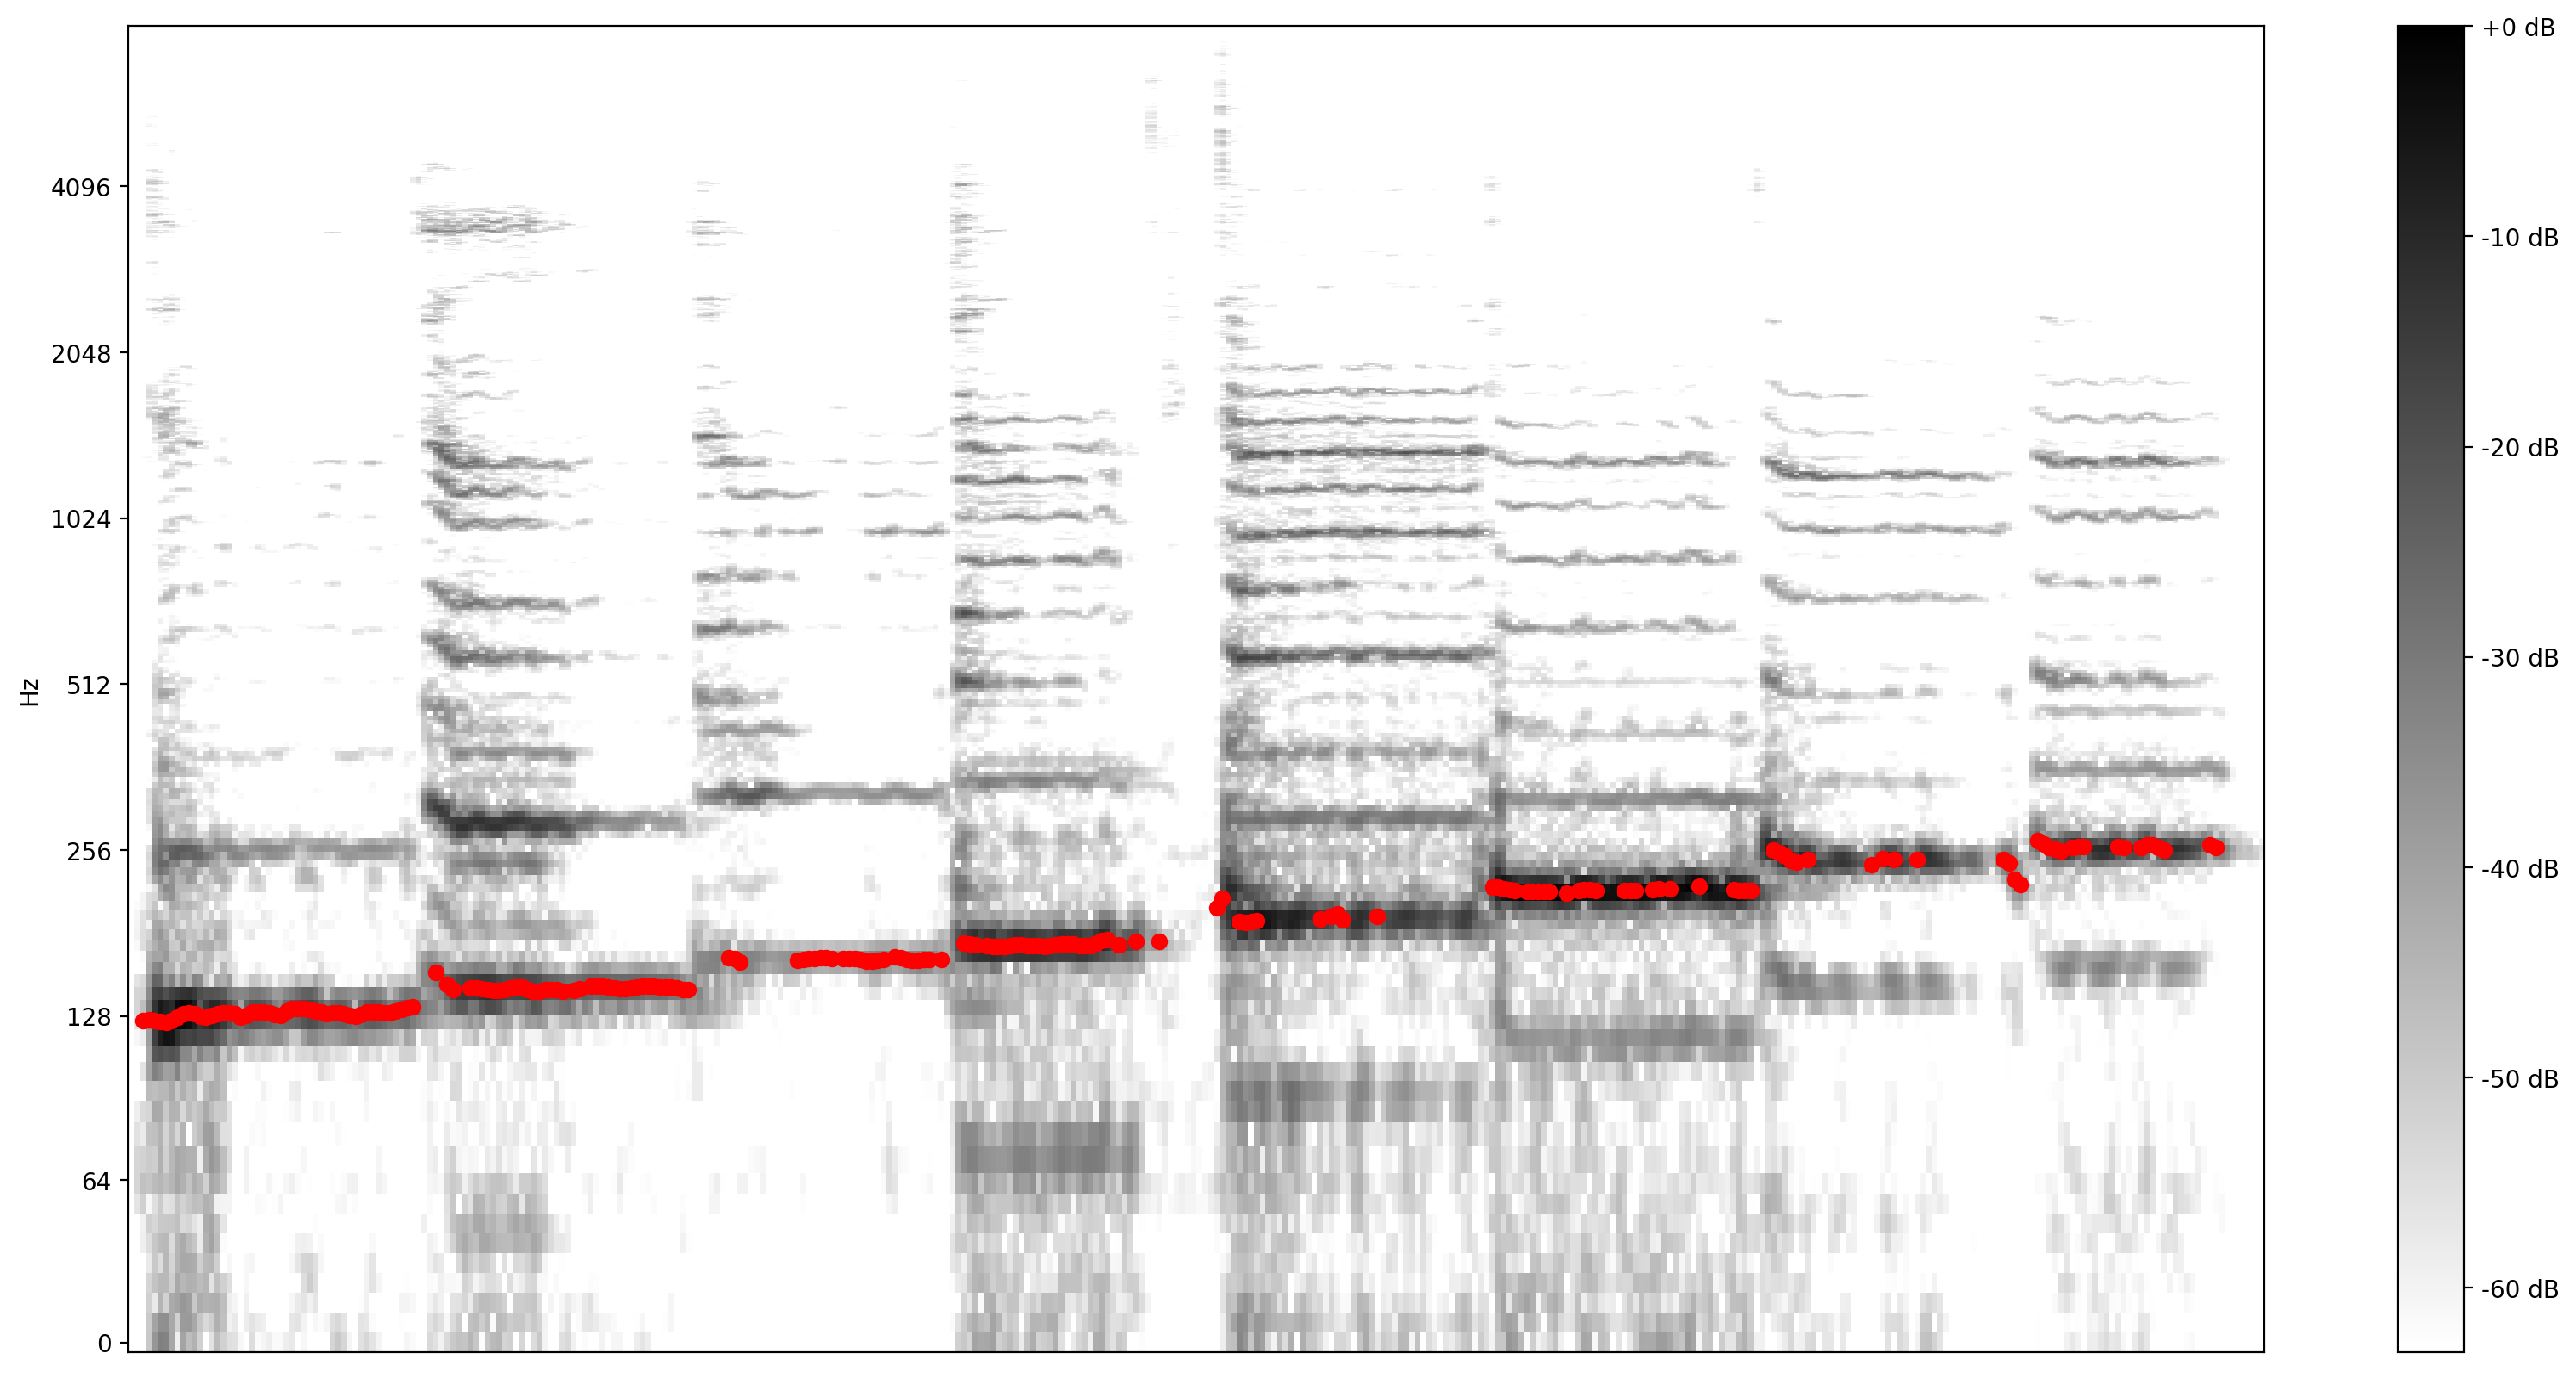

In [17]:
plot_stft(audio_samples / MAX_ABS_INT16 , 
          sample_rate=EXPECTED_SAMPLE_RATE, show_black_and_white=True)
# Note: conveniently, since the plot is in log scale, the pitch outputs 
# also get converted to the log scale automatically by matplotlib.
plt.scatter(confident_pitch_outputs_x, confident_pitch_values_hz, c="r")

plt.show()

# Converting to musical notes

Now that we have the pitch values, let's convert them to notes!
This is part is challenging by itself. We have to take into account two things:
1. the rests (when there's no singing) 
2. the size of each note (offsets) 

### 1: Adding zeros to the output to indicate when there's no singing

In [18]:
pitch_outputs_and_rests = [
    output2hz(p) if c >= 0.9 else 0
    for i, p, c in zip(indices, pitch_outputs, confidence_outputs)
]

### 2: Adding note offsets

When a person sings freely, the melody may have an offset to the absolute pitch values that notes can represent.
Hence, to convert predictions to notes, one needs to correct for this possible offset.
This is what the following code computes.

In [19]:
A4 = 440
C0 = A4 * pow(2, -4.75)
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

def hz2offset(freq):
  # This measures the quantization error for a single note.
  if freq == 0:  # Rests always have zero error.
    return None
  # Quantized note.
  h = round(12 * math.log2(freq / C0))
  return 12 * math.log2(freq / C0) - h


# The ideal offset is the mean quantization error for all the notes
# (excluding rests):
offsets = [hz2offset(p) for p in pitch_outputs_and_rests if p != 0]
print("offsets: ", offsets)

ideal_offset = statistics.mean(offsets)
print("ideal offset: ", ideal_offset)


offsets:  [0.2851056911175931, 0.3700368844097355, 0.2861639241998972, 0.19609005646164235, 0.17851549283916768, 0.2733467103665532, -0.4475316266590852, -0.24651809109990808, -0.1796576844031108, -0.23060136331860548, -0.37826153113190486, -0.4725081829601976, -0.3457194541269999, -0.2436666886383776, -0.1818906877810207, -0.1348077739650435, -0.24551812662426897, -0.4454903457934165, -0.3126792745167535, -0.12241723670307181, -0.06614479972665066, -0.06702634735648871, -0.1744116301709866, -0.29365739389006507, -0.32520890458170726, -0.0564402572685907, 0.1470525135224534, 0.17167006002122775, 0.16529058740790248, 0.09569531546290477, -0.006323616641203955, -0.11799822075907684, -0.18835098459069144, -0.17934754504506145, -0.17215607120338916, -0.23695828034226452, -0.34594501002376177, -0.39380233241860907, -0.2528674895936689, -0.11009436621014146, -0.07118973328416445, -0.08042436762396932, -0.12799598588293293, -0.16227296366040633, -0.05931985421721464, 0.1066761283701112, 0.210

We can now use some heuristics to try and estimate the most likely sequence of notes that were sung.
The ideal offset computed above is one ingredient - but we also need to know the speed (how many predictions make, say, an eighth?), and the time offset to start quantizing.  To keep it simple, we'll just try different speeds and time offsets and measure the quantization error, using in the end the values that minimize this error.

In [20]:
def quantize_predictions(group, ideal_offset):
  # Group values are either 0, or a pitch in Hz.
  non_zero_values = [v for v in group if v != 0]
  zero_values_count = len(group) - len(non_zero_values)

  # Create a rest if 80% is silent, otherwise create a note.
  if zero_values_count > 0.8 * len(group):
    # Interpret as a rest. Count each dropped note as an error, weighted a bit
    # worse than a badly sung note (which would 'cost' 0.5).
    return 0.51 * len(non_zero_values), "Rest"
  else:
    # Interpret as note, estimating as mean of non-rest predictions.
    h = round(
        statistics.mean([
            12 * math.log2(freq / C0) - ideal_offset for freq in non_zero_values
        ]))
    octave = h // 12
    n = h % 12
    note = note_names[n] + str(octave)
    # Quantization error is the total difference from the quantized note.
    error = sum([
        abs(12 * math.log2(freq / C0) - ideal_offset - h)
        for freq in non_zero_values
    ])
    return error, note


def get_quantization_and_error(pitch_outputs_and_rests, predictions_per_eighth,
                               prediction_start_offset, ideal_offset):
  # Apply the start offset - we can just add the offset as rests.
  pitch_outputs_and_rests = [0] * prediction_start_offset + \
                            pitch_outputs_and_rests
  # Collect the predictions for each note (or rest).
  groups = [
      pitch_outputs_and_rests[i:i + predictions_per_eighth]
      for i in range(0, len(pitch_outputs_and_rests), predictions_per_eighth)
  ]

  quantization_error = 0

  notes_and_rests = []
  for group in groups:
    error, note_or_rest = quantize_predictions(group, ideal_offset)
    quantization_error += error
    notes_and_rests.append(note_or_rest)

  return quantization_error, notes_and_rests


best_error = float("inf")
best_notes_and_rests = None
best_predictions_per_note = None

for predictions_per_note in range(20, 65, 1):
  for prediction_start_offset in range(predictions_per_note):

    error, notes_and_rests = get_quantization_and_error(
        pitch_outputs_and_rests, predictions_per_note,
        prediction_start_offset, ideal_offset)

    if error < best_error:      
      best_error = error
      best_notes_and_rests = notes_and_rests
      best_predictions_per_note = predictions_per_note

# At this point, best_notes_and_rests contains the best quantization.
# Since we don't need to have rests at the beginning, let's remove these:
while best_notes_and_rests[0] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[1:]
# Also remove silence at the end.
while best_notes_and_rests[-1] == 'Rest':
  best_notes_and_rests = best_notes_and_rests[:-1]

Now let's write the quantized notes as sheet music score!

To do it we will use two libraries: [music21](http://web.mit.edu/music21/) and [Open Sheet Music Display](https://github.com/opensheetmusicdisplay/opensheetmusicdisplay)

**Note:** for simplicity, we assume here that all notes have the same duration (a half note).

In [21]:
# Creating the sheet music score.
sc = music21.stream.Score()
# Adjust the speed to match the actual singing.
bpm = 60 * 60 / best_predictions_per_note
print ('bpm: ', bpm)
a = music21.tempo.MetronomeMark(number=bpm)
sc.insert(0,a)

for snote in best_notes_and_rests:   
    d = 'half'
    if snote == 'Rest':      
      sc.append(music21.note.Rest(type=d))
    else:
      sc.append(music21.note.Note(snote, type=d))

bpm:  78.26086956521739


In [22]:
#@title [Run this] Helper function to use Open Sheet Music Display (JS code) to show a music score

from IPython.core.display import display, HTML, Javascript
import json, random

def showScore(score):
    xml = open(score.write('musicxml')).read()
    showMusicXML(xml)
    
def showMusicXML(xml):
    DIV_ID = "OSMD_div"
    display(HTML('<div id="'+DIV_ID+'">loading OpenSheetMusicDisplay</div>'))
    script = """
    var div_id = %%DIV_ID%%;
    function loadOSMD() { 
        return new Promise(function(resolve, reject){
            if (window.opensheetmusicdisplay) {
                return resolve(window.opensheetmusicdisplay)
            }
            // OSMD script has a 'define' call which conflicts with requirejs
            var _define = window.define // save the define object 
            window.define = undefined // now the loaded script will ignore requirejs
            var s = document.createElement( 'script' );
            s.setAttribute( 'src', "https://cdn.jsdelivr.net/npm/opensheetmusicdisplay@0.7.6/build/opensheetmusicdisplay.min.js" );
            //s.setAttribute( 'src', "/custom/opensheetmusicdisplay.js" );
            s.onload=function(){
                window.define = _define
                resolve(opensheetmusicdisplay);
            };
            document.body.appendChild( s ); // browser will try to load the new script tag
        }) 
    }
    loadOSMD().then((OSMD)=>{
        window.openSheetMusicDisplay = new OSMD.OpenSheetMusicDisplay(div_id, {
          drawingParameters: "compacttight"
        });
        openSheetMusicDisplay
            .load(%%data%%)
            .then(
              function() {
                openSheetMusicDisplay.render();
              }
            );
    })
    """.replace('%%DIV_ID%%',DIV_ID).replace('%%data%%',json.dumps(xml))
    display(Javascript(script))
    return

/tmpfs/tmp/ipykernel_101381/2305315633.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML, Javascript


In [23]:
# rendering the music score
showScore(sc)
print(best_notes_and_rests)

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/music21/musicxml/m21ToXml.py:510: MusicXMLWarning: <music21.stream.Score 0x7f87d01c7eb0> is not well-formed; see isWellFormedNotation()
  warnings.warn(f'{scOut} is not well-formed; see isWellFormedNotation()',


<IPython.core.display.Javascript object>

['C3', 'D3', 'E3', 'F3', 'G3', 'A3', 'B3', 'C4']


Let's convert the music notes to a MIDI file and listen to it.

To create this file, we can use the stream we created before.

In [24]:
# Saving the recognized musical notes as a MIDI file
converted_audio_file_as_midi = converted_audio_file[:-4] + '.mid'
fp = sc.write('midi', fp=converted_audio_file_as_midi)

In [25]:
wav_from_created_midi = converted_audio_file_as_midi.replace(' ', '_') + "_midioutput.wav"
print(wav_from_created_midi)

converted_audio_file.mid_midioutput.wav


To listen to it on colab, we need to convert it back to wav. An easy way of doing that is using Timidity.

In [26]:
!timidity $converted_audio_file_as_midi -Ow -o $wav_from_created_midi

Playing converted_audio_file.mid
MIDI file: converted_audio_file.mid
Format: 1  Tracks: 2  Divisions: 1024
Track name: 


Playing time: ~16 seconds
Notes cut: 0
Notes lost totally: 0


And finally, listen the audio, created from notes, created via MIDI from the predicted pitches, inferred by the model!


In [27]:
Audio(wav_from_created_midi)